In [1]:
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime


import static_nda as nda
from itertools import chain
from pipeline import meso,collection,experiment
from scipy.interpolate import interp1d
from stimulus import stimulus


Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


In [2]:
scan_keys = nda.ScanInclude()

# Scan Parameters

In [3]:
print('nfields: ', set((meso.ScanInfo & scan_keys.proj()).fetch('nfields')))
print('fps: ',set((meso.ScanInfo & scan_keys.proj()).fetch('fps')))

print([p+': '+str(set((meso.ScanInfo.Field & scan_keys.proj()).fetch(p))) 
       for p in ('px_height','px_width','um_height','um_width')])

print('z spacing: ', set(chain(*[set(np.diff(sorted((meso.ScanInfo.Field & scan_key).fetch('z'))))
                                 for scan_key in scan_keys.proj()])))

min_depths = (scan_keys.proj().aggr(meso.ScanInfo.Field & scan_keys.proj(),min_depth='MIN(z)')).fetch('min_depth')
print('first plane ranging from: ', str(min(min_depths)), '-', str(max(min_depths)), 'um from surface')   


nfields:  {10}
fps:  {7.97908}
['px_height: {252}', 'px_width: {252}', 'um_height: {630.0}', 'um_width: {630.0}']
z spacing:  {5.0}
first plane ranging from:  193.0 - 218.0 um from surface


# Laser Power Calibration Curves

,curve_date,mWs,p2mW,percs
0,2018-03-27,"[5, 16, 29, 40, 52, 63, 74, 84, 95, 105, 113]",<scipy.interpolate.interpolate.interp1d object...,"[1.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
1,2019-01-01,"[1.7, 10, 19, 28, 36, 44, 52, 60, 63, 74, 80]",<scipy.interpolate.interpolate.interp1d object...,"[0.8, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
2,2019-06-13,"[2.9, 15, 27, 39, 51, 59, 72, 83, 92, 102, 110]",<scipy.interpolate.interpolate.interp1d object...,"[0.8, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
3,2019-11-01,"[1.9, 10.8, 20, 28.8, 37.5, 46.1, 54.5, 60.7, ...",<scipy.interpolate.interpolate.interp1d object...,"[0.7, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
4,2021-01-25,"[3.3, 16, 28, 41, 52, 64, 75, 87, 97, 104, 106]",<scipy.interpolate.interpolate.interp1d object...,"[0.7, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
5,2021-11-30,"[7.4, 13.8, 20.1, 26.5, 32.7, 39, 45, 51, 57.3...",<scipy.interpolate.interpolate.interp1d object...,"[5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0..."


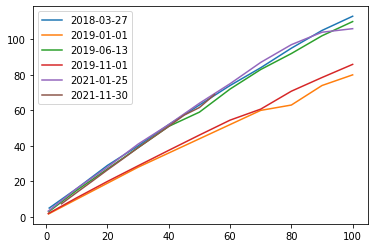

In [4]:
curve_df = pd.DataFrame()

# meso power curve, 3/27/2018
date = datetime.date(2018,3,27)
percs = np.linspace(0,100,11)
percs[0]=1
mWs = [5,16,29,40,52,63,74,84,95,105,113]
p2mW = interp1d(percs,mWs)
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve 1/?/2019
date = datetime.date(2019,1,1)
percs = np.linspace(0,100,11)
percs[0]=0.8
mWs = [1.7,10,19,28,36,44,52,60,63,74,80]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve, 6/13/2019
date = datetime.date(2019,6,13)
percs = np.linspace(0,100,11)
percs[0] = 0.8
mWs = [2.9,15,27,39,51,59,72,83,92,102,110]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve, 11/1/2019
date = datetime.date(2019,11,1)
percs = np.linspace(0,100,11)
percs[0]=0.7
mWs = [1.9,10.8,20,28.8,37.5,46.1,54.5,60.7,70.8,78.5,85.9]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve, 1/25/2021
date = datetime.date(2021,1,25)
percs = np.linspace(0,100,11)
percs[0]=0.7
mWs = [3.3,16,28,41,52,64,75,87,97,104,106]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)

# meso power curve, 11/30/2021
date = datetime.date(2021,11,30)
percs = np.linspace(5,55,11)
mWs = [7.4,13.8,20.1,26.5,32.7,39,45,51,57.3,61.6,69]
curve_df = curve_df.append({'curve_date':date,'percs':percs,'mWs':mWs,'p2mW':p2mW},ignore_index=True)


display(curve_df)

fig,ax = plt.subplots()
for d,p,mW in zip(curve_df['curve_date'],curve_df['percs'],curve_df['mWs']):
    ax.plot(p,mW,label=d)
ax.legend()

# Estimated Power Usage

In [6]:
# est_df = [{'animal_id':21067, 'session':9,  'scan_idx':17, 'est_power':28, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':21067, 'session':10, 'scan_idx':18, 'est_power':28, 'est_power_depth':218, 'est_Lz':220},
#           {'animal_id':21067, 'session':13, 'scan_idx':14, 'est_power':25, 'est_power_depth':212, 'est_Lz':220},
#           {'animal_id':22620, 'session':4,  'scan_idx':15, 'est_power':22, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':22620, 'session':4,  'scan_idx':17, 'est_power':22, 'est_power_depth':197, 'est_Lz':220},
#           {'animal_id':22620, 'session':5,  'scan_idx':11, 'est_power':22, 'est_power_depth':201, 'est_Lz':220},
#           {'animal_id':22846, 'session':2,  'scan_idx':19, 'est_power':25, 'est_power_depth':210, 'est_Lz':220},
#           {'animal_id':22846, 'session':2,  'scan_idx':21, 'est_power':25, 'est_power_depth':207, 'est_Lz':220},
#           {'animal_id':22846, 'session':7,  'scan_idx':15, 'est_power':22, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':22846, 'session':10, 'scan_idx':16, 'est_power':20, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':23343, 'session':5,  'scan_idx':17, 'est_power':18, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':23555, 'session':5,  'scan_idx':12, 'est_power':20, 'est_power_depth':200, 'est_Lz':220},
#           {'animal_id':23656, 'session':14, 'scan_idx':22, 'est_power':20, 'est_power_depth':193, 'est_Lz':220},
#           {'animal_id':23964, 'session':4,  'scan_idx':22, 'est_power':20, 'est_power_depth':200, 'est_Lz':220}]
# est_df = pd.DataFrame(est_df)
# display(est_df)

def laser_power(z,z0,Lz,P0):
    return P0 * np.exp((z-z0)/Lz)
def depth_at_power(P,P0,Lz,z0):
    return log(P/P0) * Lz + z0

scanimage_df = []
for scan in scan_keys.proj():
    date = (experiment.Session & scan).fetch1('session_date')
    scan_filename = (experiment.Scan() & scan).local_filenames_as_wildcard
    scan_filename = scan_filename.replace('*','_00001')
    t = tifffile.TiffFile(scan_filename)
    Lz = t.scanimage_metadata['FrameData']['SI.hBeams.lengthConstants']
    P0 = t.scanimage_metadata['FrameData']['SI.hBeams.powers']
    min_z = min((meso.ScanInfo.Field & scan).fetch('z'))
    max_z = max((meso.ScanInfo.Field & scan).fetch('z'))
    
    time_diff = list(date-curve_df['curve_date'])
    min_diff = min(i for i in time_diff if i > timedelta(0))
    curve_idx = time_diff.index(min_diff)
    curve_info = curve_df.loc[[curve_idx]]
    
    
    scanimage_df.append({**scan,'curve_date':curve_df.loc[curve_idx,'curve_date'],
                         'mw_at_first_plane':np.round(curve_df.loc[curve_idx,'p2mW'](P0),2),
                         'mw_at_last_plane':np.round(curve_df.loc[curve_idx,'p2mW'](laser_power(max_z,min_z,Lz,P0)),2),
                         'mw_at_zero':np.round(curve_df.loc[curve_idx,'p2mW'](laser_power(0,min_z,Lz,P0)),2),
                         'date':date,'scanimage_Lz':Lz, 
                         'scanimage_perc_at_first_plane':P0, 
                         'scanimage_min_z':min_z, 'scanimage_max_z':max_z})
    
#     scanimage_df.append({**scan,'Lz':Lz, 'perc_at_zero':P0,'mw_at_zero':np.round(p2mW(P0),2),
#                           'depth_of_max_power':np.round(depth_at_power(mW2p(np.max(mWs)),P0,Lz,0),2)})
scanimage_df = pd.DataFrame(scanimage_df)
display(scanimage_df)

,animal_id,session,scan_idx,curve_date,mw_at_first_plane,mw_at_last_plane,mw_at_zero,date,scanimage_Lz,scanimage_perc_at_first_plane,scanimage_min_z,scanimage_max_z
0,21067,10,18,2019-01-01,37.8,45.23,16.51,2019-04-03,220,28,218.0,263.0
1,22846,10,16,2019-11-01,29.0,33.99,13.63,2019-12-04,220,20,200.0,245.0
2,23343,5,17,2019-11-01,26.4,31.29,12.64,2020-01-15,220,18,200.0,245.0
3,23656,14,22,2019-11-01,29.0,33.99,13.94,2020-04-30,220,20,193.0,238.0
4,23964,4,22,2019-11-01,29.0,33.99,13.63,2020-06-29,220,20,200.0,245.0
5,26644,14,17,2021-11-30,29.0,33.99,13.63,2021-12-13,220,20,200.0,245.0
6,26645,2,18,2021-11-30,52.0,61.99,23.95,2021-12-14,220,40,200.0,245.0
